# Train Model on Baron - Human Dataset

In this notebook, we're going to train our model using the Baron Human dataset. 

This assumes that you've made the graph using the ```Infer GRN.ipynb``` code.

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Data, Dataset
from tqdm import tqdm
from datasetmuraro import MuraroDataset
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

Torch version: 1.9.0+cu102
Cuda available: True
Torch geometric version: 1.7.1


In [2]:
dataset = MuraroDataset("/gpfs/data/rsingh47/hzaki1/data-muraro")

100%|██████████| 368087/368087 [00:24<00:00, 15218.63it/s]


In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MuraroDataset(2122):
Number of graphs: 2122
Number of features: 1

Data(edge_index=[2, 368087], x=[18915], y=[1])
Number of nodes: 18915
Number of edges: 368087
Average node degree: 19.46
Contains isolated nodes: True
Contains self-loops: False
Is undirected: False


In [4]:
shuffle_index = np.loadtxt('/gpfs/data/rsingh47/hzaki1/data-muraro/resources/shuffle_index_Muraro.txt')
shuffle_index = shuffle_index.astype(np.int32)
train_size, val_size = int(len(shuffle_index)* 0.8), int(len(shuffle_index)* 0.9)
train_data = [dataset[i] for i in shuffle_index[0:train_size]]
val_data = [dataset[i] for i in shuffle_index[train_size: val_size]]
test_data =  [dataset[i] for i in shuffle_index[val_size:]]

In [5]:
# torch.manual_seed(12345)
# dataset = dataset.shuffle()

# #train_dataset = torch.load('trainDataset.pt')
# #test_dataset = torch.load('testDataset.pt')

# train_dataset = dataset[:6856]
# test_dataset = dataset[6856:]
# #test_dataset = dataset[-12:]


# # train_dataset = dataset[:40]
# # test_dataset = dataset[40:60]

# print(f'Number of training graphs: {len(train_dataset)}')
# print(f'Number of test graphs: {len(test_dataset)}')

In [6]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_data, batch_size=30, shuffle=True)
val_loader = DataLoader(val_data, batch_size=30, shuffle=True)
test_loader = DataLoader(test_data, batch_size=30, shuffle=False)

In [7]:
from gcnmodel import GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=128, data=dataset, output_size=14).to(device)
print(model)

GCN(
  (conv1): SAGEConv(1, 128)
  (conv2): SAGEConv(128, 128)
  (conv3): SAGEConv(128, 128)
  (lin): Linear(in_features=128, out_features=14, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    avgLoss = 0
    for data in tqdm(train_loader, total=57):  # Iterate in batches over the training dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)# Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        avgLoss += loss
    return avgLoss / 229

def test(loader):
    model.eval()

    correct = 0
    avgAUC = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        avgAUCbatch = 0
        aucCounter = 0
        one_hot = np.eye(14)[data.y.cpu()]
        for i in range(0,14):
            try:
                roc = roc_auc_score(one_hot[:,i], out.cpu().detach().numpy()[:,i])
                avgAUCbatch += roc
                aucCounter +=1
            except Exception as e:
                continue
        if aucCounter == 0:
            continue
        avgAUC += avgAUCbatch/aucCounter
    return correct / len(loader.dataset), avgAUC / len(loader)  # Derive ratio of correct predictions.


for epoch in range(1, 250):
    loss = train()
    train_acc, trainAUC = test(train_loader)
    test_acc,testAUC = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train AUC: {trainAUC:.4f}, Test Acc: {test_acc:.4f}, Test Auc: {testAUC:.4f}, Loss: {loss:.4f}')

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 001, Train Acc: 0.5716, Train AUC: 0.7009, Test Acc: 0.5587, Test Auc: 0.6863, Loss: 3.0477


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 002, Train Acc: 0.6199, Train AUC: 0.6957, Test Acc: 0.6103, Test Auc: 0.6815, Loss: 0.4165


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 003, Train Acc: 0.5209, Train AUC: 0.6874, Test Acc: 0.5023, Test Auc: 0.6736, Loss: 0.3762


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 004, Train Acc: 0.6382, Train AUC: 0.7088, Test Acc: 0.6103, Test Auc: 0.6947, Loss: 0.3600


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 005, Train Acc: 0.6176, Train AUC: 0.7434, Test Acc: 0.5962, Test Auc: 0.7477, Loss: 0.3503


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 006, Train Acc: 0.5934, Train AUC: 0.8165, Test Acc: 0.5634, Test Auc: 0.8333, Loss: 0.3412


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 007, Train Acc: 0.6517, Train AUC: 0.6927, Test Acc: 0.6197, Test Auc: 0.7220, Loss: 0.3327


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 008, Train Acc: 0.6523, Train AUC: 0.6738, Test Acc: 0.6338, Test Auc: 0.6926, Loss: 0.3256


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 009, Train Acc: 0.6417, Train AUC: 0.7504, Test Acc: 0.6150, Test Auc: 0.7688, Loss: 0.3187


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 010, Train Acc: 0.6423, Train AUC: 0.7501, Test Acc: 0.6103, Test Auc: 0.7631, Loss: 0.3138


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 011, Train Acc: 0.6600, Train AUC: 0.7327, Test Acc: 0.6432, Test Auc: 0.7539, Loss: 0.3111


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 012, Train Acc: 0.6629, Train AUC: 0.7642, Test Acc: 0.6338, Test Auc: 0.7989, Loss: 0.3108


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 013, Train Acc: 0.6476, Train AUC: 0.7898, Test Acc: 0.6150, Test Auc: 0.8192, Loss: 0.3152


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 014, Train Acc: 0.6671, Train AUC: 0.7271, Test Acc: 0.6620, Test Auc: 0.7496, Loss: 0.3089


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 015, Train Acc: 0.6741, Train AUC: 0.7570, Test Acc: 0.6620, Test Auc: 0.7731, Loss: 0.3160


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 016, Train Acc: 0.6011, Train AUC: 0.6858, Test Acc: 0.5775, Test Auc: 0.6613, Loss: 0.3022


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 017, Train Acc: 0.6341, Train AUC: 0.6711, Test Acc: 0.6056, Test Auc: 0.6852, Loss: 0.3306


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 018, Train Acc: 0.6458, Train AUC: 0.7142, Test Acc: 0.6197, Test Auc: 0.7263, Loss: 0.3112


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 019, Train Acc: 0.6706, Train AUC: 0.6815, Test Acc: 0.6620, Test Auc: 0.6853, Loss: 0.3063


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 020, Train Acc: 0.6441, Train AUC: 0.6911, Test Acc: 0.6103, Test Auc: 0.6999, Loss: 0.2975


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 021, Train Acc: 0.6759, Train AUC: 0.7322, Test Acc: 0.6854, Test Auc: 0.7525, Loss: 0.2960


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 022, Train Acc: 0.6730, Train AUC: 0.7412, Test Acc: 0.6338, Test Auc: 0.7610, Loss: 0.2967


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 023, Train Acc: 0.6741, Train AUC: 0.8106, Test Acc: 0.6620, Test Auc: 0.8386, Loss: 0.2923


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 024, Train Acc: 0.6612, Train AUC: 0.7987, Test Acc: 0.6338, Test Auc: 0.8084, Loss: 0.2951


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 025, Train Acc: 0.6747, Train AUC: 0.7553, Test Acc: 0.6620, Test Auc: 0.7625, Loss: 0.2899


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 026, Train Acc: 0.6730, Train AUC: 0.8186, Test Acc: 0.6854, Test Auc: 0.8427, Loss: 0.2813


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 027, Train Acc: 0.6730, Train AUC: 0.8204, Test Acc: 0.6808, Test Auc: 0.8479, Loss: 0.2834


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 028, Train Acc: 0.6771, Train AUC: 0.8268, Test Acc: 0.6432, Test Auc: 0.8475, Loss: 0.2748


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 029, Train Acc: 0.6859, Train AUC: 0.8139, Test Acc: 0.6761, Test Auc: 0.8454, Loss: 0.2733


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 030, Train Acc: 0.6771, Train AUC: 0.8248, Test Acc: 0.6620, Test Auc: 0.8494, Loss: 0.2835


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 031, Train Acc: 0.6830, Train AUC: 0.8341, Test Acc: 0.6432, Test Auc: 0.8574, Loss: 0.2823


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 032, Train Acc: 0.6871, Train AUC: 0.8147, Test Acc: 0.6901, Test Auc: 0.8459, Loss: 0.2735


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 033, Train Acc: 0.6647, Train AUC: 0.8195, Test Acc: 0.6385, Test Auc: 0.8412, Loss: 0.2756


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 034, Train Acc: 0.6977, Train AUC: 0.8296, Test Acc: 0.7042, Test Auc: 0.8569, Loss: 0.2603


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 035, Train Acc: 0.6783, Train AUC: 0.8251, Test Acc: 0.6620, Test Auc: 0.8459, Loss: 0.2757


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 036, Train Acc: 0.7148, Train AUC: 0.8204, Test Acc: 0.7277, Test Auc: 0.8504, Loss: 0.2950


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 037, Train Acc: 0.7107, Train AUC: 0.8363, Test Acc: 0.7089, Test Auc: 0.8550, Loss: 0.2578


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 038, Train Acc: 0.6953, Train AUC: 0.8366, Test Acc: 0.6808, Test Auc: 0.8678, Loss: 0.2544


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 039, Train Acc: 0.7272, Train AUC: 0.8396, Test Acc: 0.7089, Test Auc: 0.8672, Loss: 0.2490


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 040, Train Acc: 0.6959, Train AUC: 0.7946, Test Acc: 0.6854, Test Auc: 0.8073, Loss: 0.2944


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 041, Train Acc: 0.7525, Train AUC: 0.7955, Test Acc: 0.7371, Test Auc: 0.8046, Loss: 0.2491


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 042, Train Acc: 0.7171, Train AUC: 0.8300, Test Acc: 0.6948, Test Auc: 0.8545, Loss: 0.2494


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 043, Train Acc: 0.7071, Train AUC: 0.8313, Test Acc: 0.6761, Test Auc: 0.8506, Loss: 0.2486


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 044, Train Acc: 0.7189, Train AUC: 0.8542, Test Acc: 0.6854, Test Auc: 0.8661, Loss: 0.2380


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 045, Train Acc: 0.7295, Train AUC: 0.8405, Test Acc: 0.7559, Test Auc: 0.8591, Loss: 0.2392


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 046, Train Acc: 0.3111, Train AUC: 0.8433, Test Acc: 0.3286, Test Auc: 0.8809, Loss: 0.2345


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 047, Train Acc: 0.7596, Train AUC: 0.8647, Test Acc: 0.7465, Test Auc: 0.8750, Loss: 0.2377


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 048, Train Acc: 0.7507, Train AUC: 0.8502, Test Acc: 0.7465, Test Auc: 0.8721, Loss: 0.2374


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 049, Train Acc: 0.7372, Train AUC: 0.8441, Test Acc: 0.7042, Test Auc: 0.8654, Loss: 0.2250


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 050, Train Acc: 0.7537, Train AUC: 0.8588, Test Acc: 0.7418, Test Auc: 0.8732, Loss: 0.2219


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 051, Train Acc: 0.7708, Train AUC: 0.8680, Test Acc: 0.7700, Test Auc: 0.8820, Loss: 0.2221


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 052, Train Acc: 0.7331, Train AUC: 0.8752, Test Acc: 0.7371, Test Auc: 0.8908, Loss: 0.2211


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 053, Train Acc: 0.7955, Train AUC: 0.8746, Test Acc: 0.7746, Test Auc: 0.8881, Loss: 0.2255


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 054, Train Acc: 0.7955, Train AUC: 0.8816, Test Acc: 0.7746, Test Auc: 0.8900, Loss: 0.2131


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 055, Train Acc: 0.7861, Train AUC: 0.8837, Test Acc: 0.7981, Test Auc: 0.8937, Loss: 0.2053


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 056, Train Acc: 0.7625, Train AUC: 0.8824, Test Acc: 0.7277, Test Auc: 0.8973, Loss: 0.2068


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 057, Train Acc: 0.7790, Train AUC: 0.8844, Test Acc: 0.7746, Test Auc: 0.8955, Loss: 0.2224


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 058, Train Acc: 0.8061, Train AUC: 0.8970, Test Acc: 0.8075, Test Auc: 0.9030, Loss: 0.2088


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 059, Train Acc: 0.7631, Train AUC: 0.8927, Test Acc: 0.7606, Test Auc: 0.9012, Loss: 0.2082


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 060, Train Acc: 0.7914, Train AUC: 0.8987, Test Acc: 0.7746, Test Auc: 0.9058, Loss: 0.2024


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 061, Train Acc: 0.8103, Train AUC: 0.8969, Test Acc: 0.7934, Test Auc: 0.9037, Loss: 0.1948


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 062, Train Acc: 0.8244, Train AUC: 0.8892, Test Acc: 0.8169, Test Auc: 0.8950, Loss: 0.1976


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 063, Train Acc: 0.8156, Train AUC: 0.9039, Test Acc: 0.8263, Test Auc: 0.9077, Loss: 0.1895


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 064, Train Acc: 0.8150, Train AUC: 0.9004, Test Acc: 0.8028, Test Auc: 0.9007, Loss: 0.1915


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 065, Train Acc: 0.8203, Train AUC: 0.9008, Test Acc: 0.7793, Test Auc: 0.9119, Loss: 0.1929


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 066, Train Acc: 0.8456, Train AUC: 0.9092, Test Acc: 0.8122, Test Auc: 0.9122, Loss: 0.1893


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 067, Train Acc: 0.8574, Train AUC: 0.9146, Test Acc: 0.8451, Test Auc: 0.9173, Loss: 0.1798


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 068, Train Acc: 0.8521, Train AUC: 0.9088, Test Acc: 0.8310, Test Auc: 0.9132, Loss: 0.1782


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 069, Train Acc: 0.8480, Train AUC: 0.9061, Test Acc: 0.8169, Test Auc: 0.9096, Loss: 0.1737


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 070, Train Acc: 0.8544, Train AUC: 0.9160, Test Acc: 0.8075, Test Auc: 0.9140, Loss: 0.1820


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 071, Train Acc: 0.8639, Train AUC: 0.9192, Test Acc: 0.8592, Test Auc: 0.9147, Loss: 0.1713


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 072, Train Acc: 0.8586, Train AUC: 0.9209, Test Acc: 0.8592, Test Auc: 0.9232, Loss: 0.1725


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 073, Train Acc: 0.8704, Train AUC: 0.9200, Test Acc: 0.8732, Test Auc: 0.9193, Loss: 0.1680


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 074, Train Acc: 0.8586, Train AUC: 0.9286, Test Acc: 0.8451, Test Auc: 0.9254, Loss: 0.1672


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 075, Train Acc: 0.8733, Train AUC: 0.9212, Test Acc: 0.8779, Test Auc: 0.9217, Loss: 0.1616


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 076, Train Acc: 0.8704, Train AUC: 0.9272, Test Acc: 0.8263, Test Auc: 0.9296, Loss: 0.1604


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 077, Train Acc: 0.8816, Train AUC: 0.9307, Test Acc: 0.8404, Test Auc: 0.9307, Loss: 0.1550


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 078, Train Acc: 0.8821, Train AUC: 0.9317, Test Acc: 0.8685, Test Auc: 0.9257, Loss: 0.1551


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 079, Train Acc: 0.8680, Train AUC: 0.9318, Test Acc: 0.8169, Test Auc: 0.9331, Loss: 0.1572


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 080, Train Acc: 0.8963, Train AUC: 0.9403, Test Acc: 0.9014, Test Auc: 0.9389, Loss: 0.1549


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 081, Train Acc: 0.8798, Train AUC: 0.9340, Test Acc: 0.8685, Test Auc: 0.9316, Loss: 0.1495


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 082, Train Acc: 0.8780, Train AUC: 0.9408, Test Acc: 0.8310, Test Auc: 0.9381, Loss: 0.1567


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 083, Train Acc: 0.9051, Train AUC: 0.9347, Test Acc: 0.9014, Test Auc: 0.9351, Loss: 0.1509


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 084, Train Acc: 0.8998, Train AUC: 0.9389, Test Acc: 0.8732, Test Auc: 0.9356, Loss: 0.1360


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 085, Train Acc: 0.8497, Train AUC: 0.9241, Test Acc: 0.8498, Test Auc: 0.9242, Loss: 0.1518


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 086, Train Acc: 0.8928, Train AUC: 0.9346, Test Acc: 0.8967, Test Auc: 0.9361, Loss: 0.1512


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 087, Train Acc: 0.8904, Train AUC: 0.9359, Test Acc: 0.8967, Test Auc: 0.9396, Loss: 0.1579


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 088, Train Acc: 0.8857, Train AUC: 0.9344, Test Acc: 0.8498, Test Auc: 0.9376, Loss: 0.1429


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 089, Train Acc: 0.9045, Train AUC: 0.9455, Test Acc: 0.8826, Test Auc: 0.9437, Loss: 0.1384


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 090, Train Acc: 0.8992, Train AUC: 0.9416, Test Acc: 0.9061, Test Auc: 0.9420, Loss: 0.1394


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 091, Train Acc: 0.9039, Train AUC: 0.9461, Test Acc: 0.8826, Test Auc: 0.9401, Loss: 0.1362


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 092, Train Acc: 0.9022, Train AUC: 0.9487, Test Acc: 0.8592, Test Auc: 0.9451, Loss: 0.1378


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 093, Train Acc: 0.8833, Train AUC: 0.9435, Test Acc: 0.8310, Test Auc: 0.9400, Loss: 0.1352


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 094, Train Acc: 0.9028, Train AUC: 0.9449, Test Acc: 0.8779, Test Auc: 0.9467, Loss: 0.1509


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 095, Train Acc: 0.9028, Train AUC: 0.9438, Test Acc: 0.8826, Test Auc: 0.9422, Loss: 0.1312


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 096, Train Acc: 0.9175, Train AUC: 0.9449, Test Acc: 0.9061, Test Auc: 0.9437, Loss: 0.1312


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 097, Train Acc: 0.8845, Train AUC: 0.9497, Test Acc: 0.8357, Test Auc: 0.9412, Loss: 0.1299


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 098, Train Acc: 0.9075, Train AUC: 0.9461, Test Acc: 0.8967, Test Auc: 0.9511, Loss: 0.1296


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 099, Train Acc: 0.9175, Train AUC: 0.9444, Test Acc: 0.8826, Test Auc: 0.9479, Loss: 0.1372


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 100, Train Acc: 0.9240, Train AUC: 0.9504, Test Acc: 0.9155, Test Auc: 0.9501, Loss: 0.1315


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 101, Train Acc: 0.9039, Train AUC: 0.9468, Test Acc: 0.8826, Test Auc: 0.9465, Loss: 0.1198


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 102, Train Acc: 0.9116, Train AUC: 0.9508, Test Acc: 0.8920, Test Auc: 0.9510, Loss: 0.1174


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 103, Train Acc: 0.9181, Train AUC: 0.9455, Test Acc: 0.8826, Test Auc: 0.9483, Loss: 0.1154


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 104, Train Acc: 0.9163, Train AUC: 0.9539, Test Acc: 0.9108, Test Auc: 0.9501, Loss: 0.1182


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 105, Train Acc: 0.9252, Train AUC: 0.9550, Test Acc: 0.9249, Test Auc: 0.9537, Loss: 0.1168


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 106, Train Acc: 0.9199, Train AUC: 0.9539, Test Acc: 0.9061, Test Auc: 0.9517, Loss: 0.1253


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 107, Train Acc: 0.9193, Train AUC: 0.9577, Test Acc: 0.8873, Test Auc: 0.9573, Loss: 0.1195


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 108, Train Acc: 0.9246, Train AUC: 0.9454, Test Acc: 0.8967, Test Auc: 0.9531, Loss: 0.1201


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 109, Train Acc: 0.9222, Train AUC: 0.9539, Test Acc: 0.9061, Test Auc: 0.9588, Loss: 0.1143


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 110, Train Acc: 0.9246, Train AUC: 0.9617, Test Acc: 0.9014, Test Auc: 0.9629, Loss: 0.1115


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 111, Train Acc: 0.9175, Train AUC: 0.9573, Test Acc: 0.9108, Test Auc: 0.9634, Loss: 0.1124


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 112, Train Acc: 0.9281, Train AUC: 0.9531, Test Acc: 0.8920, Test Auc: 0.9548, Loss: 0.1156


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 113, Train Acc: 0.9322, Train AUC: 0.9584, Test Acc: 0.9061, Test Auc: 0.9600, Loss: 0.1088


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 114, Train Acc: 0.9222, Train AUC: 0.9573, Test Acc: 0.8967, Test Auc: 0.9554, Loss: 0.1021


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 115, Train Acc: 0.9381, Train AUC: 0.9573, Test Acc: 0.8967, Test Auc: 0.9621, Loss: 0.1082


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 116, Train Acc: 0.9275, Train AUC: 0.9618, Test Acc: 0.9014, Test Auc: 0.9586, Loss: 0.1068


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 117, Train Acc: 0.9393, Train AUC: 0.9634, Test Acc: 0.9014, Test Auc: 0.9674, Loss: 0.1043


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 118, Train Acc: 0.9375, Train AUC: 0.9609, Test Acc: 0.9108, Test Auc: 0.9606, Loss: 0.1086


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 119, Train Acc: 0.9381, Train AUC: 0.9667, Test Acc: 0.8967, Test Auc: 0.9602, Loss: 0.1053


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 120, Train Acc: 0.9458, Train AUC: 0.9622, Test Acc: 0.9343, Test Auc: 0.9616, Loss: 0.0962


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 121, Train Acc: 0.9393, Train AUC: 0.9666, Test Acc: 0.9108, Test Auc: 0.9671, Loss: 0.1029


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 122, Train Acc: 0.9423, Train AUC: 0.9651, Test Acc: 0.8967, Test Auc: 0.9622, Loss: 0.1072


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 123, Train Acc: 0.9316, Train AUC: 0.9653, Test Acc: 0.9061, Test Auc: 0.9599, Loss: 0.1035


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 124, Train Acc: 0.9252, Train AUC: 0.9646, Test Acc: 0.8967, Test Auc: 0.9677, Loss: 0.1055


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 125, Train Acc: 0.9428, Train AUC: 0.9693, Test Acc: 0.9202, Test Auc: 0.9700, Loss: 0.1094


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 126, Train Acc: 0.9322, Train AUC: 0.9675, Test Acc: 0.9108, Test Auc: 0.9703, Loss: 0.1015


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 127, Train Acc: 0.9423, Train AUC: 0.9707, Test Acc: 0.9296, Test Auc: 0.9724, Loss: 0.0997


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 128, Train Acc: 0.9458, Train AUC: 0.9644, Test Acc: 0.9061, Test Auc: 0.9600, Loss: 0.1088


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 129, Train Acc: 0.9440, Train AUC: 0.9703, Test Acc: 0.9108, Test Auc: 0.9698, Loss: 0.1018


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 130, Train Acc: 0.9328, Train AUC: 0.9711, Test Acc: 0.9202, Test Auc: 0.9713, Loss: 0.1080


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 131, Train Acc: 0.9199, Train AUC: 0.9739, Test Acc: 0.8826, Test Auc: 0.9707, Loss: 0.0924


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 132, Train Acc: 0.9476, Train AUC: 0.9680, Test Acc: 0.9249, Test Auc: 0.9682, Loss: 0.0964


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 133, Train Acc: 0.9476, Train AUC: 0.9756, Test Acc: 0.8967, Test Auc: 0.9677, Loss: 0.0952


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 134, Train Acc: 0.9269, Train AUC: 0.9662, Test Acc: 0.8920, Test Auc: 0.9629, Loss: 0.0926


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 135, Train Acc: 0.9340, Train AUC: 0.9751, Test Acc: 0.8967, Test Auc: 0.9702, Loss: 0.0928


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 136, Train Acc: 0.9281, Train AUC: 0.9685, Test Acc: 0.8732, Test Auc: 0.9691, Loss: 0.1037


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 137, Train Acc: 0.9387, Train AUC: 0.9737, Test Acc: 0.9155, Test Auc: 0.9719, Loss: 0.0943


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 138, Train Acc: 0.9428, Train AUC: 0.9697, Test Acc: 0.9061, Test Auc: 0.9672, Loss: 0.0970


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 139, Train Acc: 0.9428, Train AUC: 0.9706, Test Acc: 0.9108, Test Auc: 0.9705, Loss: 0.0956


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 140, Train Acc: 0.9423, Train AUC: 0.9732, Test Acc: 0.8920, Test Auc: 0.9652, Loss: 0.0890


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 141, Train Acc: 0.9452, Train AUC: 0.9731, Test Acc: 0.8967, Test Auc: 0.9723, Loss: 0.0916


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 142, Train Acc: 0.9216, Train AUC: 0.9774, Test Acc: 0.8545, Test Auc: 0.9673, Loss: 0.0944


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 143, Train Acc: 0.9534, Train AUC: 0.9754, Test Acc: 0.9108, Test Auc: 0.9718, Loss: 0.0975


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 144, Train Acc: 0.9440, Train AUC: 0.9791, Test Acc: 0.9014, Test Auc: 0.9759, Loss: 0.0920


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 145, Train Acc: 0.9434, Train AUC: 0.9749, Test Acc: 0.9202, Test Auc: 0.9721, Loss: 0.0852


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 146, Train Acc: 0.9481, Train AUC: 0.9790, Test Acc: 0.9249, Test Auc: 0.9707, Loss: 0.0903


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 147, Train Acc: 0.9593, Train AUC: 0.9782, Test Acc: 0.9296, Test Auc: 0.9704, Loss: 0.0913


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 148, Train Acc: 0.9440, Train AUC: 0.9781, Test Acc: 0.8873, Test Auc: 0.9729, Loss: 0.0927


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 149, Train Acc: 0.9405, Train AUC: 0.9686, Test Acc: 0.9108, Test Auc: 0.9673, Loss: 0.0905


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 150, Train Acc: 0.9352, Train AUC: 0.9803, Test Acc: 0.8967, Test Auc: 0.9746, Loss: 0.0900


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 151, Train Acc: 0.9517, Train AUC: 0.9746, Test Acc: 0.9202, Test Auc: 0.9728, Loss: 0.0953


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 152, Train Acc: 0.9493, Train AUC: 0.9760, Test Acc: 0.9155, Test Auc: 0.9736, Loss: 0.0856


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 153, Train Acc: 0.9487, Train AUC: 0.9826, Test Acc: 0.8920, Test Auc: 0.9755, Loss: 0.0783


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 154, Train Acc: 0.9617, Train AUC: 0.9774, Test Acc: 0.9202, Test Auc: 0.9742, Loss: 0.0813


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 155, Train Acc: 0.9646, Train AUC: 0.9801, Test Acc: 0.9202, Test Auc: 0.9754, Loss: 0.0836


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 156, Train Acc: 0.9576, Train AUC: 0.9822, Test Acc: 0.9249, Test Auc: 0.9766, Loss: 0.0836


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 157, Train Acc: 0.9493, Train AUC: 0.9774, Test Acc: 0.9296, Test Auc: 0.9753, Loss: 0.0812


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 158, Train Acc: 0.9470, Train AUC: 0.9766, Test Acc: 0.8967, Test Auc: 0.9678, Loss: 0.0799


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 159, Train Acc: 0.9517, Train AUC: 0.9795, Test Acc: 0.9202, Test Auc: 0.9717, Loss: 0.0914


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 160, Train Acc: 0.9599, Train AUC: 0.9822, Test Acc: 0.9202, Test Auc: 0.9745, Loss: 0.0834


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 161, Train Acc: 0.9558, Train AUC: 0.9838, Test Acc: 0.9249, Test Auc: 0.9738, Loss: 0.0787


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 162, Train Acc: 0.9617, Train AUC: 0.9817, Test Acc: 0.9155, Test Auc: 0.9755, Loss: 0.0795


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 163, Train Acc: 0.9558, Train AUC: 0.9787, Test Acc: 0.9014, Test Auc: 0.9731, Loss: 0.0874


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 164, Train Acc: 0.9529, Train AUC: 0.9821, Test Acc: 0.9155, Test Auc: 0.9773, Loss: 0.0828


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 165, Train Acc: 0.9576, Train AUC: 0.9857, Test Acc: 0.9343, Test Auc: 0.9779, Loss: 0.0839


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 166, Train Acc: 0.9635, Train AUC: 0.9799, Test Acc: 0.9155, Test Auc: 0.9743, Loss: 0.0723


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 167, Train Acc: 0.9641, Train AUC: 0.9834, Test Acc: 0.9249, Test Auc: 0.9753, Loss: 0.0870


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 168, Train Acc: 0.9529, Train AUC: 0.9838, Test Acc: 0.9202, Test Auc: 0.9749, Loss: 0.0853


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 169, Train Acc: 0.9505, Train AUC: 0.9796, Test Acc: 0.9108, Test Auc: 0.9745, Loss: 0.0784


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 170, Train Acc: 0.9582, Train AUC: 0.9775, Test Acc: 0.9296, Test Auc: 0.9776, Loss: 0.0752


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 171, Train Acc: 0.9517, Train AUC: 0.9833, Test Acc: 0.8873, Test Auc: 0.9726, Loss: 0.0768


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 172, Train Acc: 0.9605, Train AUC: 0.9838, Test Acc: 0.9202, Test Auc: 0.9748, Loss: 0.0741


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 173, Train Acc: 0.9664, Train AUC: 0.9807, Test Acc: 0.9202, Test Auc: 0.9748, Loss: 0.0774


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 174, Train Acc: 0.9617, Train AUC: 0.9838, Test Acc: 0.9202, Test Auc: 0.9725, Loss: 0.0768


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 175, Train Acc: 0.9629, Train AUC: 0.9852, Test Acc: 0.9155, Test Auc: 0.9759, Loss: 0.0723


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 176, Train Acc: 0.9593, Train AUC: 0.9841, Test Acc: 0.9108, Test Auc: 0.9745, Loss: 0.0757


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 177, Train Acc: 0.9694, Train AUC: 0.9833, Test Acc: 0.9249, Test Auc: 0.9737, Loss: 0.0703


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 178, Train Acc: 0.9534, Train AUC: 0.9854, Test Acc: 0.9061, Test Auc: 0.9744, Loss: 0.0646


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 179, Train Acc: 0.9688, Train AUC: 0.9852, Test Acc: 0.9437, Test Auc: 0.9753, Loss: 0.0753


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 180, Train Acc: 0.9617, Train AUC: 0.9844, Test Acc: 0.9202, Test Auc: 0.9713, Loss: 0.0726


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 181, Train Acc: 0.9670, Train AUC: 0.9879, Test Acc: 0.9202, Test Auc: 0.9772, Loss: 0.0769


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 182, Train Acc: 0.9375, Train AUC: 0.9802, Test Acc: 0.9108, Test Auc: 0.9729, Loss: 0.0733


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 183, Train Acc: 0.9434, Train AUC: 0.9841, Test Acc: 0.8779, Test Auc: 0.9728, Loss: 0.0710


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 184, Train Acc: 0.9729, Train AUC: 0.9870, Test Acc: 0.9296, Test Auc: 0.9755, Loss: 0.0758


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 185, Train Acc: 0.9629, Train AUC: 0.9845, Test Acc: 0.9343, Test Auc: 0.9790, Loss: 0.0738


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 186, Train Acc: 0.9658, Train AUC: 0.9843, Test Acc: 0.9390, Test Auc: 0.9787, Loss: 0.0745


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 187, Train Acc: 0.9688, Train AUC: 0.9844, Test Acc: 0.9296, Test Auc: 0.9762, Loss: 0.0716


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 188, Train Acc: 0.9617, Train AUC: 0.9839, Test Acc: 0.9390, Test Auc: 0.9784, Loss: 0.0774


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 189, Train Acc: 0.9658, Train AUC: 0.9844, Test Acc: 0.9343, Test Auc: 0.9777, Loss: 0.0707


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 190, Train Acc: 0.9552, Train AUC: 0.9847, Test Acc: 0.9155, Test Auc: 0.9763, Loss: 0.0655


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 191, Train Acc: 0.9328, Train AUC: 0.9757, Test Acc: 0.8967, Test Auc: 0.9642, Loss: 0.0868


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 192, Train Acc: 0.9511, Train AUC: 0.9792, Test Acc: 0.9061, Test Auc: 0.9721, Loss: 0.0913


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 193, Train Acc: 0.9664, Train AUC: 0.9855, Test Acc: 0.9108, Test Auc: 0.9780, Loss: 0.0735


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 194, Train Acc: 0.9517, Train AUC: 0.9817, Test Acc: 0.9061, Test Auc: 0.9723, Loss: 0.0687


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 195, Train Acc: 0.9623, Train AUC: 0.9848, Test Acc: 0.9390, Test Auc: 0.9761, Loss: 0.0785


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 196, Train Acc: 0.9670, Train AUC: 0.9878, Test Acc: 0.9249, Test Auc: 0.9760, Loss: 0.0629


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 197, Train Acc: 0.9605, Train AUC: 0.9806, Test Acc: 0.8967, Test Auc: 0.9699, Loss: 0.0733


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 198, Train Acc: 0.9570, Train AUC: 0.9829, Test Acc: 0.8967, Test Auc: 0.9734, Loss: 0.0695


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 199, Train Acc: 0.9694, Train AUC: 0.9843, Test Acc: 0.9296, Test Auc: 0.9755, Loss: 0.0735


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 200, Train Acc: 0.9699, Train AUC: 0.9828, Test Acc: 0.9437, Test Auc: 0.9733, Loss: 0.0682


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 201, Train Acc: 0.9688, Train AUC: 0.9825, Test Acc: 0.9390, Test Auc: 0.9767, Loss: 0.0695


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 202, Train Acc: 0.9646, Train AUC: 0.9873, Test Acc: 0.8967, Test Auc: 0.9756, Loss: 0.0679


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 203, Train Acc: 0.9699, Train AUC: 0.9871, Test Acc: 0.9155, Test Auc: 0.9765, Loss: 0.0697


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 204, Train Acc: 0.9652, Train AUC: 0.9887, Test Acc: 0.9155, Test Auc: 0.9773, Loss: 0.0776


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 205, Train Acc: 0.9670, Train AUC: 0.9852, Test Acc: 0.9202, Test Auc: 0.9790, Loss: 0.0788


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 206, Train Acc: 0.9481, Train AUC: 0.9861, Test Acc: 0.8685, Test Auc: 0.9759, Loss: 0.0687


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 207, Train Acc: 0.9694, Train AUC: 0.9866, Test Acc: 0.9202, Test Auc: 0.9774, Loss: 0.0712


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 208, Train Acc: 0.9735, Train AUC: 0.9855, Test Acc: 0.9343, Test Auc: 0.9773, Loss: 0.0636


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 209, Train Acc: 0.9670, Train AUC: 0.9901, Test Acc: 0.9202, Test Auc: 0.9785, Loss: 0.0731


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 210, Train Acc: 0.9741, Train AUC: 0.9885, Test Acc: 0.9343, Test Auc: 0.9785, Loss: 0.0644


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 211, Train Acc: 0.9735, Train AUC: 0.9888, Test Acc: 0.9296, Test Auc: 0.9776, Loss: 0.0592


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 212, Train Acc: 0.9682, Train AUC: 0.9885, Test Acc: 0.9296, Test Auc: 0.9815, Loss: 0.0657


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 213, Train Acc: 0.9764, Train AUC: 0.9895, Test Acc: 0.9202, Test Auc: 0.9779, Loss: 0.0581


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 214, Train Acc: 0.9764, Train AUC: 0.9869, Test Acc: 0.9296, Test Auc: 0.9759, Loss: 0.0643


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 215, Train Acc: 0.9788, Train AUC: 0.9888, Test Acc: 0.9390, Test Auc: 0.9762, Loss: 0.0707


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 216, Train Acc: 0.9764, Train AUC: 0.9907, Test Acc: 0.9061, Test Auc: 0.9759, Loss: 0.0690


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 217, Train Acc: 0.9741, Train AUC: 0.9882, Test Acc: 0.9296, Test Auc: 0.9764, Loss: 0.0635


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 218, Train Acc: 0.9741, Train AUC: 0.9885, Test Acc: 0.9296, Test Auc: 0.9740, Loss: 0.0626


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 219, Train Acc: 0.9635, Train AUC: 0.9891, Test Acc: 0.9155, Test Auc: 0.9787, Loss: 0.0577


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 220, Train Acc: 0.9711, Train AUC: 0.9870, Test Acc: 0.9296, Test Auc: 0.9767, Loss: 0.0626


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 221, Train Acc: 0.9770, Train AUC: 0.9887, Test Acc: 0.9343, Test Auc: 0.9779, Loss: 0.0656


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 222, Train Acc: 0.9694, Train AUC: 0.9893, Test Acc: 0.9390, Test Auc: 0.9754, Loss: 0.0575


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 223, Train Acc: 0.9753, Train AUC: 0.9896, Test Acc: 0.9484, Test Auc: 0.9786, Loss: 0.0601


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 224, Train Acc: 0.9723, Train AUC: 0.9910, Test Acc: 0.9202, Test Auc: 0.9765, Loss: 0.0620


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 225, Train Acc: 0.9776, Train AUC: 0.9890, Test Acc: 0.9343, Test Auc: 0.9771, Loss: 0.0617


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 226, Train Acc: 0.9794, Train AUC: 0.9917, Test Acc: 0.9296, Test Auc: 0.9748, Loss: 0.0593


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 227, Train Acc: 0.9788, Train AUC: 0.9919, Test Acc: 0.9343, Test Auc: 0.9797, Loss: 0.0616


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 228, Train Acc: 0.9729, Train AUC: 0.9902, Test Acc: 0.9249, Test Auc: 0.9749, Loss: 0.0548


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 229, Train Acc: 0.9705, Train AUC: 0.9903, Test Acc: 0.9390, Test Auc: 0.9767, Loss: 0.0598


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 230, Train Acc: 0.9711, Train AUC: 0.9896, Test Acc: 0.9202, Test Auc: 0.9746, Loss: 0.0620


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 231, Train Acc: 0.9764, Train AUC: 0.9918, Test Acc: 0.9343, Test Auc: 0.9755, Loss: 0.0651


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 232, Train Acc: 0.9717, Train AUC: 0.9890, Test Acc: 0.9014, Test Auc: 0.9748, Loss: 0.0616


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 233, Train Acc: 0.9758, Train AUC: 0.9892, Test Acc: 0.9249, Test Auc: 0.9753, Loss: 0.0671


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 234, Train Acc: 0.9753, Train AUC: 0.9869, Test Acc: 0.9202, Test Auc: 0.9757, Loss: 0.0607


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 235, Train Acc: 0.9699, Train AUC: 0.9900, Test Acc: 0.9061, Test Auc: 0.9755, Loss: 0.0550


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 236, Train Acc: 0.9776, Train AUC: 0.9901, Test Acc: 0.9249, Test Auc: 0.9766, Loss: 0.0517


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 237, Train Acc: 0.9829, Train AUC: 0.9906, Test Acc: 0.9296, Test Auc: 0.9779, Loss: 0.0489


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 238, Train Acc: 0.9794, Train AUC: 0.9909, Test Acc: 0.9390, Test Auc: 0.9767, Loss: 0.0570


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 239, Train Acc: 0.9782, Train AUC: 0.9913, Test Acc: 0.9249, Test Auc: 0.9765, Loss: 0.0684


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 240, Train Acc: 0.9776, Train AUC: 0.9896, Test Acc: 0.9296, Test Auc: 0.9773, Loss: 0.0624


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 241, Train Acc: 0.9782, Train AUC: 0.9897, Test Acc: 0.9343, Test Auc: 0.9753, Loss: 0.0582


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 242, Train Acc: 0.9800, Train AUC: 0.9903, Test Acc: 0.9249, Test Auc: 0.9755, Loss: 0.0552


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 243, Train Acc: 0.9835, Train AUC: 0.9880, Test Acc: 0.9155, Test Auc: 0.9765, Loss: 0.0580


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 244, Train Acc: 0.9729, Train AUC: 0.9892, Test Acc: 0.9343, Test Auc: 0.9744, Loss: 0.0564


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 245, Train Acc: 0.9782, Train AUC: 0.9907, Test Acc: 0.9296, Test Auc: 0.9750, Loss: 0.0593


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 246, Train Acc: 0.9770, Train AUC: 0.9897, Test Acc: 0.9202, Test Auc: 0.9760, Loss: 0.0613


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 247, Train Acc: 0.9829, Train AUC: 0.9912, Test Acc: 0.9296, Test Auc: 0.9766, Loss: 0.0610


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 248, Train Acc: 0.9806, Train AUC: 0.9888, Test Acc: 0.9343, Test Auc: 0.9758, Loss: 0.0554


100%|██████████| 57/57 [00:13<00:00,  4.10it/s]


Epoch: 249, Train Acc: 0.9811, Train AUC: 0.9924, Test Acc: 0.9343, Test Auc: 0.9746, Loss: 0.0638


In [9]:
print(len(train_loader))

57


In [10]:
torch.save(model.state_dict(), 'model_weightsOct16Muraro.pth')

In [ ]:
yee = {}
for data in train_loader:
    wow = data.y.detach().numpy()[0]
    if wow in yee:
        yee[wow] +=1
    else:
        yee[wow] = 0

In [ ]:
yee

In [11]:
def testForAUC(loader):
    model.eval()

    correct = 0
    avgAUC = 0
    toReturn = np.zeros((len(loader), 14))
    ind = 0
    actual = np.zeros((len(loader), 14))
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        toReturn[ind] = out.cpu().detach().numpy()
        actual[ind][data.y] = 1
        ind+=1
    return toReturn, actual

In [12]:
test_loader_auc = DataLoader(test_data, batch_size=1, shuffle=False)
predics, test_labels = testForAUC(test_loader_auc)

In [13]:
print(test_labels.shape)
print(predics.shape)

(213, 14)
(213, 14)


/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Text(0, 0.5, 'True Positive Rate')

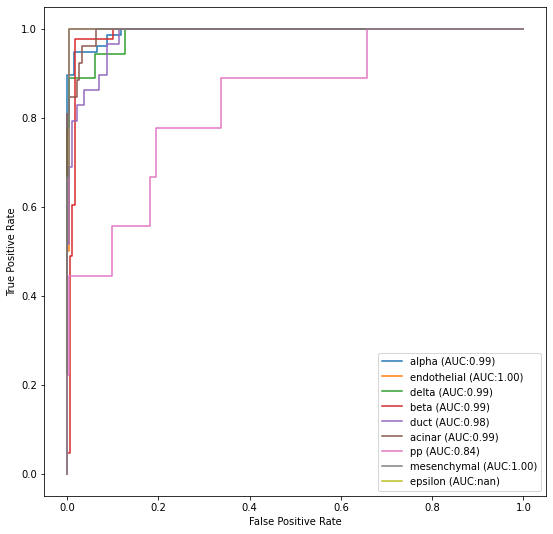

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

all_labels = list(dataset.cellToIndex.keys())
test_labels = np.array(test_labels)

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_labels[:,idx].astype(int), predics[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

In [ ]:
print(test_labels)
b = np.zeros_like(predics)
b[np.arange(len(predics)), predics.argmax(1)] = 1
print(b)

In [ ]:
torch.save(train_dataset, 'train_loader_aug24.pt')
torch.save(test_dataset, 'test_loader_aug24.pt')

In [ ]:
model.load_state_dict(torch.load('model_weightsSept20BaronHuman.pth'))

In [ ]:
from sklearn.metrics import average_precision_score

def testForAUPR(loader):
    model.eval()

    correct = 0
    avgAUC = 0
    toReturn = np.zeros((len(loader), 14))
    ind = 0
    actual = np.zeros((len(loader), 14))
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        wowow = average_precision_score(data.y.cpu().detach().numpy(), out.cpu().detach().numpy(), average='micro')
        print(wowowow)
    
testForAUPR(test_loader)